# Tutorial: Creating Vision+Text RAG Pipelines

- **Level**: Intermediate
- **Time to complete**: 20 minutes
- **Components Used**: [`SentenceTransformersDocumentImageEmbedder`](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentimageembedder), [`ImageFileToDocument`](https://docs.haystack.deepset.ai/docs/imagefiletodocument), [`DocumentToImageContent`](https://docs.haystack.deepset.ai/docs/documenttoimagecontent), [`DocumentTypeRouter`](https://docs.haystack.deepset.ai/docs/documenttyperouter), [`LLMDocumentContentExtractor`](https://docs.haystack.deepset.ai/docs/llmdocumentcontentextractor)
- **Prerequisites**: You need an [OpenAI API Key](https://platform.openai.com/api-keys)
- **Goal**: After completing this tutorial, you'll have learned how to index and retrieve images using Haystack and build a RAG pipeline that can answer questions grounded in both images and text.

## Overview

In this notebook, you'll learn how to index and retrieve images using Haystack. By the end, you'll be able to build a Retrieval-Augmented Generation (RAG) pipeline that can answer questions grounded in both images and text. This is useful when working with datasets like scientific papers, diagrams, or screenshots where meaning is spread across modalities.

This tutorial uses the following **new components** that enable image indexing:

- `SentenceTransformersDocumentImageEmbedder`: Embed image documents with CLIP-based models
- `ImageFileToDocument`: Convert image files into Haystack `Document`s
- `DocumentTypeRouter`: Route retrieved documents by mime type (e.g., image vs text)
- `DocumentToImageContent`: Convert image documents into `ImageContent` to be processed by our ChatGenerator
- `LLMDocumentContentExtractor`: Extracts textual content from image-based documents using a vision-enabled LLM.

In this notebook, we'll introduce all these features, show an application using **image + text retrieval + multimodal generation**.

## Setup Development Environment

First, let's install required packages:

In [1]:
%%bash

pip install -q "haystack-ai>=2.16.0" pillow pypdf pypdfium2 "sentence-transformers>=4.1.0"

Enter your API key for OpenAI:

In [2]:
import os
from getpass import getpass


if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


## Introduction to Embedding Images

Let's compare the similarity between a text and two images.

First, let's download two sample images, one of an apple and one of a Capybara.

In [ ]:
from urllib.request import URLopener

url_opener = URLopener()
url_opener.addheader("User-Agent", "Mozilla/5.0")

url_opener.retrieve("https://upload.wikimedia.org/wikipedia/commons/2/26/Pink_Lady_Apple_%284107712628%29.jpg?download", "apple.jpg")
url_opener.retrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg/960px-Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg?download", "capybara.jpg")

('capybara.jpg', <http.client.HTTPMessage at 0x7b1a2bfad8d0>)

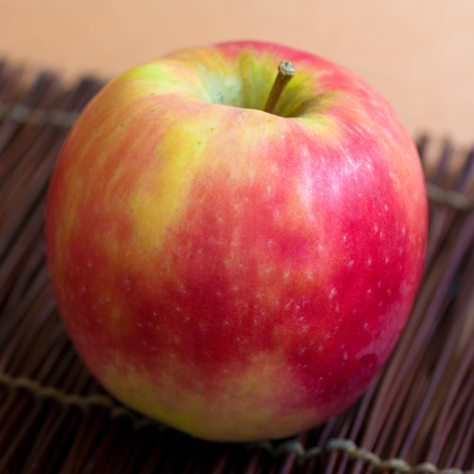

In [4]:
from PIL import Image

img = Image.open("apple.jpg")
# We resize the image here just to avoid it taking up too much space in the notebook
img_resized = img.resize((img.width // 6, img.height // 6))
img_resized

Next, we convert our Image Files into Haystack `Documents` so they can be used downstream in our `SentenceTransformersDocumentImageEmbedder` component.

In [5]:
from haystack.components.converters.image import ImageFileToDocument

image_file_converter = ImageFileToDocument()
image_docs = image_file_converter.run(sources=["apple.jpg", "capybara.jpg"])["documents"]
print(image_docs)

[Document(id=ab81e5b007d0016dc2221538326671e672f4f88f12abc4eae624332cf8dc812e, meta: {'file_path': 'apple.jpg'}), Document(id=ff6efc0b376f144dd8cc665bffb167407f6db031d4b3a408847d05d452124bca, meta: {'file_path': 'capybara.jpg'})]


Next, we load our embedders with the [sentence-transformers/clip-ViT-L-14](https://huggingface.co/sentence-transformers/clip-ViT-L-14) model that maps text and images to a shared vector space. It's important that we use the same CLIP model for both text and images to calculate the similarity between.

In [ ]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.embedders.image import SentenceTransformersDocumentImageEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/clip-ViT-L-14", progress_bar=False)
image_embedder = SentenceTransformersDocumentImageEmbedder(
    model="sentence-transformers/clip-ViT-L-14", progress_bar=False
)

# Warm up the models to load them
text_embedder.warm_up()
image_embedder.warm_up()

Let's run the embedders and create vector embeddings for images to see how semantically similar our query is to the two images.

In [8]:
import torch
from sentence_transformers import util

query = "A red apple on a white background"
text_embedding = text_embedder.run(text=query)["embedding"]
image_docs_with_embeddings = image_embedder.run(image_docs)["documents"]

# Compare the similarities between the query and two image documents
for doc in image_docs_with_embeddings:
    similarity = util.cos_sim(torch.tensor(text_embedding), torch.tensor(doc.embedding))
    print(f"Similarity with {doc.meta['file_path'].split('/')[-1]}: {similarity.item():.2f}")

Similarity with apple.jpg: 0.27
Similarity with capybara.jpg: 0.07


As we can see, the text is most similar to our Apple image, as expected! So, the CLIP model can create correct representations for images and text.

## Multimodal Retrieval with Image and Text Embeddings

In this approach, we'll use the `sentence-transformers/clip-ViT-L-14` model to create embeddings for both image and text, and perform retrieval using these embeddings.

First, let's download a sample PDF file to see how we can retrieve over both text and image based documents

In [ ]:
from urllib.request import URLopener

url_opener = URLopener()
url_opener.addheader("User-Agent", "Mozilla/5.0")

url_opener.retrieve("https://arxiv.org/pdf/1706.03762", "attention_is_all_you_need.pdf")

('attention_is_all_you_need.pdf', <http.client.HTTPMessage at 0x7b18b6e08390>)

### Building an Image + Text Indexing Pipeline

Let's create an indexing pipeline to process our image and PDF files at once and write them to our Document Store.

So in the following `Pipeline`, we are:
- computing embeddings based on images for image files
- converting PDF files to textual Documents and then computing embeddings based on the text

In [12]:
from haystack import Pipeline
from haystack.components.converters import PyPDFToDocument
from haystack.components.converters.image import ImageFileToDocument
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.embedders.image import SentenceTransformersDocumentImageEmbedder
from haystack.components.joiners import DocumentJoiner
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.routers.file_type_router import FileTypeRouter
from haystack.components.writers.document_writer import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

# Create our document store
doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

# Define our components
file_type_router = FileTypeRouter(mime_types=["application/pdf", "image/jpeg"])
final_doc_joiner = DocumentJoiner(sort_by_score=False)
image_converter = ImageFileToDocument()
pdf_converter = PyPDFToDocument()
pdf_splitter = DocumentSplitter(split_by="page", split_length=1)
text_doc_embedder = SentenceTransformersDocumentEmbedder(
    model="sentence-transformers/clip-ViT-L-14", progress_bar=False
)
image_embedder = SentenceTransformersDocumentImageEmbedder(
    model="sentence-transformers/clip-ViT-L-14", progress_bar=False
)
document_writer = DocumentWriter(doc_store)

In [13]:
# Create the Indexing Pipeline
indexing_pipe = Pipeline()
indexing_pipe.add_component("file_type_router", file_type_router)
indexing_pipe.add_component("pdf_converter", pdf_converter)
indexing_pipe.add_component("pdf_splitter", pdf_splitter)
indexing_pipe.add_component("image_converter", image_converter)
indexing_pipe.add_component("text_doc_embedder", text_doc_embedder)
indexing_pipe.add_component("image_doc_embedder", image_embedder)
indexing_pipe.add_component("final_doc_joiner", final_doc_joiner)
indexing_pipe.add_component("document_writer", document_writer)

indexing_pipe.connect("file_type_router.application/pdf", "pdf_converter.sources")
indexing_pipe.connect("pdf_converter.documents", "pdf_splitter.documents")
indexing_pipe.connect("pdf_splitter.documents", "text_doc_embedder.documents")
indexing_pipe.connect("file_type_router.image/jpeg", "image_converter.sources")
indexing_pipe.connect("image_converter.documents", "image_doc_embedder.documents")
indexing_pipe.connect("text_doc_embedder.documents", "final_doc_joiner.documents")
indexing_pipe.connect("image_doc_embedder.documents", "final_doc_joiner.documents")
indexing_pipe.connect("final_doc_joiner.documents", "document_writer.documents")

🚅 Components
  - file_type_router: FileTypeRouter
  - pdf_converter: PyPDFToDocument
  - pdf_splitter: DocumentSplitter
  - image_converter: ImageFileToDocument
  - text_doc_embedder: SentenceTransformersDocumentEmbedder
  - image_doc_embedder: SentenceTransformersDocumentImageEmbedder
  - final_doc_joiner: DocumentJoiner
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pdf_converter.sources (List[Union[str, Path, ByteStream]])
  - file_type_router.image/jpeg -> image_converter.sources (List[Union[str, Path, ByteStream]])
  - pdf_converter.documents -> pdf_splitter.documents (List[Document])
  - pdf_splitter.documents -> text_doc_embedder.documents (List[Document])
  - image_converter.documents -> image_doc_embedder.documents (List[Document])
  - text_doc_embedder.documents -> final_doc_joiner.documents (List[Document])
  - image_doc_embedder.documents -> final_doc_joiner.documents (List[Document])
  - final_doc_joiner.documents -> document_wri

Visualize the Indexing pipeline

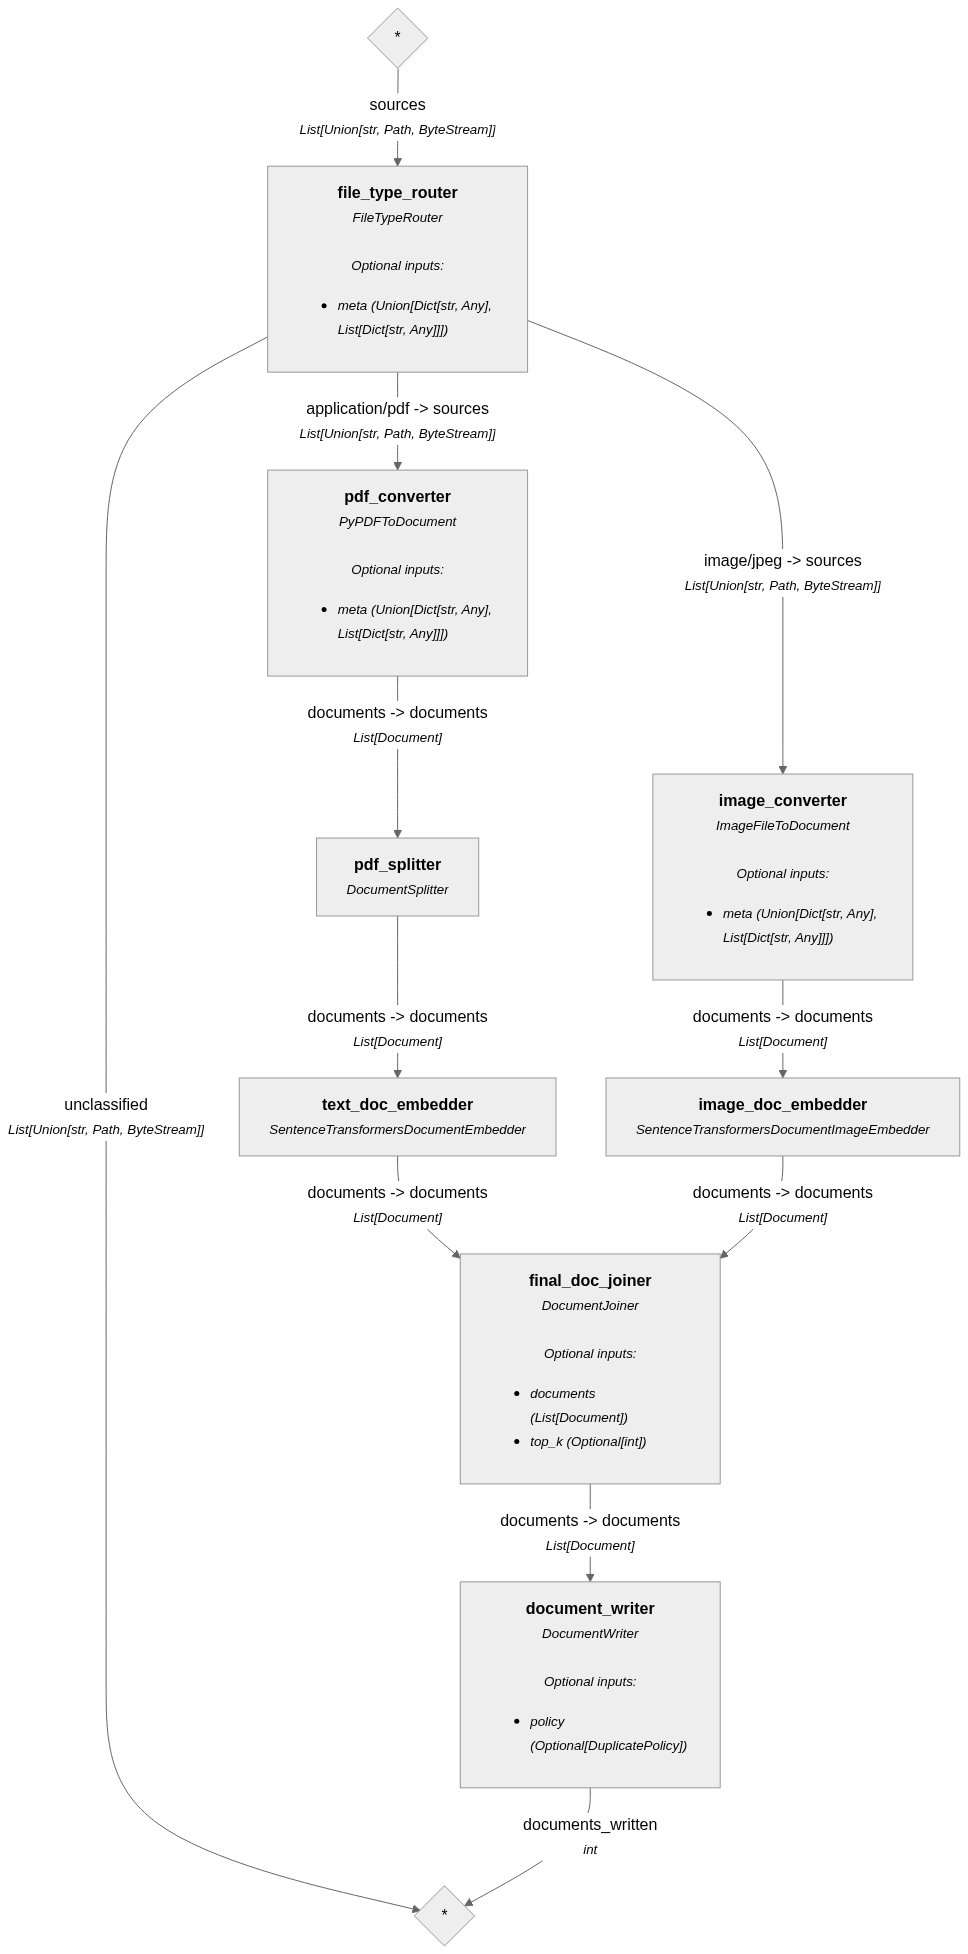

In [ ]:
# indexing_pipe.show()

Run the indexing pipeline with a pdf and an image file.

In [14]:
indexing_result = indexing_pipe.run(
    data={"file_type_router": {"sources": ["attention_is_all_you_need.pdf", "apple.jpg"]}}
)

Inspect the documents

In [15]:
indexed_documents = doc_store.filter_documents()
print(f"Indexed {len(indexed_documents)} documents")

Indexed 16 documents


### Searching Image + Text

Let's now set up our search and retrieve relevant data from our document store by passing a query.

In [16]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store=doc_store)
text_embedding = text_embedder.run(text="An image of an apple")["embedding"]
results = retriever.run(text_embedding)["documents"]

for idx, doc in enumerate(results[:5]):
    print(f"Document {idx+1}:")
    print(f"Score: {doc.score}")
    print(f"File Path: {doc.meta['file_path']}")
    print("")

Document 1:
Score: 0.575790009328374
File Path: attention_is_all_you_need.pdf

Document 2:
Score: 0.575790009328374
File Path: attention_is_all_you_need.pdf

Document 3:
Score: 0.5112777878281352
File Path: attention_is_all_you_need.pdf

Document 4:
Score: 0.500057394071375
File Path: attention_is_all_you_need.pdf

Document 5:
Score: 0.485217826700958
File Path: attention_is_all_you_need.pdf



Huh how odd! It doesn't seem like any of the top results are relevant. In fact it seems like the top retrieved documents are text-based no matter how irrelevant they are.

This is actually a common scenario when trying to run multimodal retrieval with both images and text at the same time. Often times the underlying embedding model (CLIP in this case) is not trained to handle both text and image documents at the same time and can be biased towards one type. In this case the model we have chosen appears to be biased towards text to text similarities which we can observe by the scores attached to each Document.

Side Note: It's possible more recent models like [jina-embeddings-v4](https://huggingface.co/jinaai/jina-embeddings-v4) or [Cohere Embed 4](https://cohere.com/blog/embed-4) might work better for this type of scenario.

To combat this, let's use a slightly different approach below.

## Multimodal Retrieval with (Only) Text Embeddings

In this approach, we will use the `LLMDocumentContentExtractor` to first extract a textual representation of all images before writing them to our DocumentStore.

- This will allow us to use text-only retrieval methods when searching through our DocumentStore.
- We will still send the actual image to the Vision LLM. This is helpful since it's possible that the image contains more information and nuance than the extracted version.

### Building an Image + Text Indexing Pipeline using the LLMDocumentContentExtractor


This time, in the following `Pipeline`, we are:
- extracting the textual representation of images with `LLMDocumentContentExtractor`
- converting PDF files to textual Documents
- creating text embeddings for both PDF and image files' text content using [`mixedbread-ai/mxbai-embed-large-v1`](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [17]:
from haystack import Pipeline
from haystack.components.converters import PyPDFToDocument
from haystack.components.converters.image import ImageFileToDocument
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.embedders.image import SentenceTransformersDocumentImageEmbedder
from haystack.components.joiners import DocumentJoiner
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.routers.file_type_router import FileTypeRouter
from haystack.components.writers.document_writer import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.extractors.image import LLMDocumentContentExtractor

# Create our document store
doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

# Define our components
file_type_router = FileTypeRouter(mime_types=["application/pdf", "image/jpeg"])
image_converter = ImageFileToDocument()
pdf_converter = PyPDFToDocument()
pdf_splitter = DocumentSplitter(split_by="page", split_length=1)
final_doc_joiner = DocumentJoiner(sort_by_score=False)
document_writer = DocumentWriter(doc_store)

# Now we use high-performing text-only embedders
doc_embedder = SentenceTransformersDocumentEmbedder(model="mixedbread-ai/mxbai-embed-large-v1", progress_bar=False)

# New LLMDocumentContentExtractor
llm_content_extractor = LLMDocumentContentExtractor(
    chat_generator=OpenAIChatGenerator(model="gpt-4o-mini"), # you can replace this with other chat generators that support vision
    max_workers=1,  # This can be used to parallelize the content extraction
)

In [18]:
# Create the Indexing Pipeline
indexing_pipe = Pipeline()
indexing_pipe.add_component("file_type_router", file_type_router)
indexing_pipe.add_component("pdf_converter", pdf_converter)
indexing_pipe.add_component("pdf_splitter", pdf_splitter)
indexing_pipe.add_component("image_converter", image_converter)
indexing_pipe.add_component("llm_content_extractor", llm_content_extractor)
indexing_pipe.add_component("doc_embedder", doc_embedder)
indexing_pipe.add_component("final_doc_joiner", final_doc_joiner)
indexing_pipe.add_component("document_writer", document_writer)

indexing_pipe.connect("file_type_router.application/pdf", "pdf_converter.sources")
indexing_pipe.connect("pdf_converter.documents", "pdf_splitter.documents")
indexing_pipe.connect("pdf_splitter.documents", "final_doc_joiner.documents")
indexing_pipe.connect("file_type_router.image/jpeg", "image_converter.sources")
indexing_pipe.connect("image_converter.documents", "llm_content_extractor.documents")
indexing_pipe.connect("llm_content_extractor.documents", "final_doc_joiner.documents")
indexing_pipe.connect("final_doc_joiner.documents", "doc_embedder.documents")
indexing_pipe.connect("doc_embedder.documents", "document_writer.documents")

🚅 Components
  - file_type_router: FileTypeRouter
  - pdf_converter: PyPDFToDocument
  - pdf_splitter: DocumentSplitter
  - image_converter: ImageFileToDocument
  - llm_content_extractor: LLMDocumentContentExtractor
  - doc_embedder: SentenceTransformersDocumentEmbedder
  - final_doc_joiner: DocumentJoiner
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pdf_converter.sources (List[Union[str, Path, ByteStream]])
  - file_type_router.image/jpeg -> image_converter.sources (List[Union[str, Path, ByteStream]])
  - pdf_converter.documents -> pdf_splitter.documents (List[Document])
  - pdf_splitter.documents -> final_doc_joiner.documents (List[Document])
  - image_converter.documents -> llm_content_extractor.documents (List[Document])
  - llm_content_extractor.documents -> final_doc_joiner.documents (List[Document])
  - doc_embedder.documents -> document_writer.documents (List[Document])
  - final_doc_joiner.documents -> doc_embedder.documents (List[

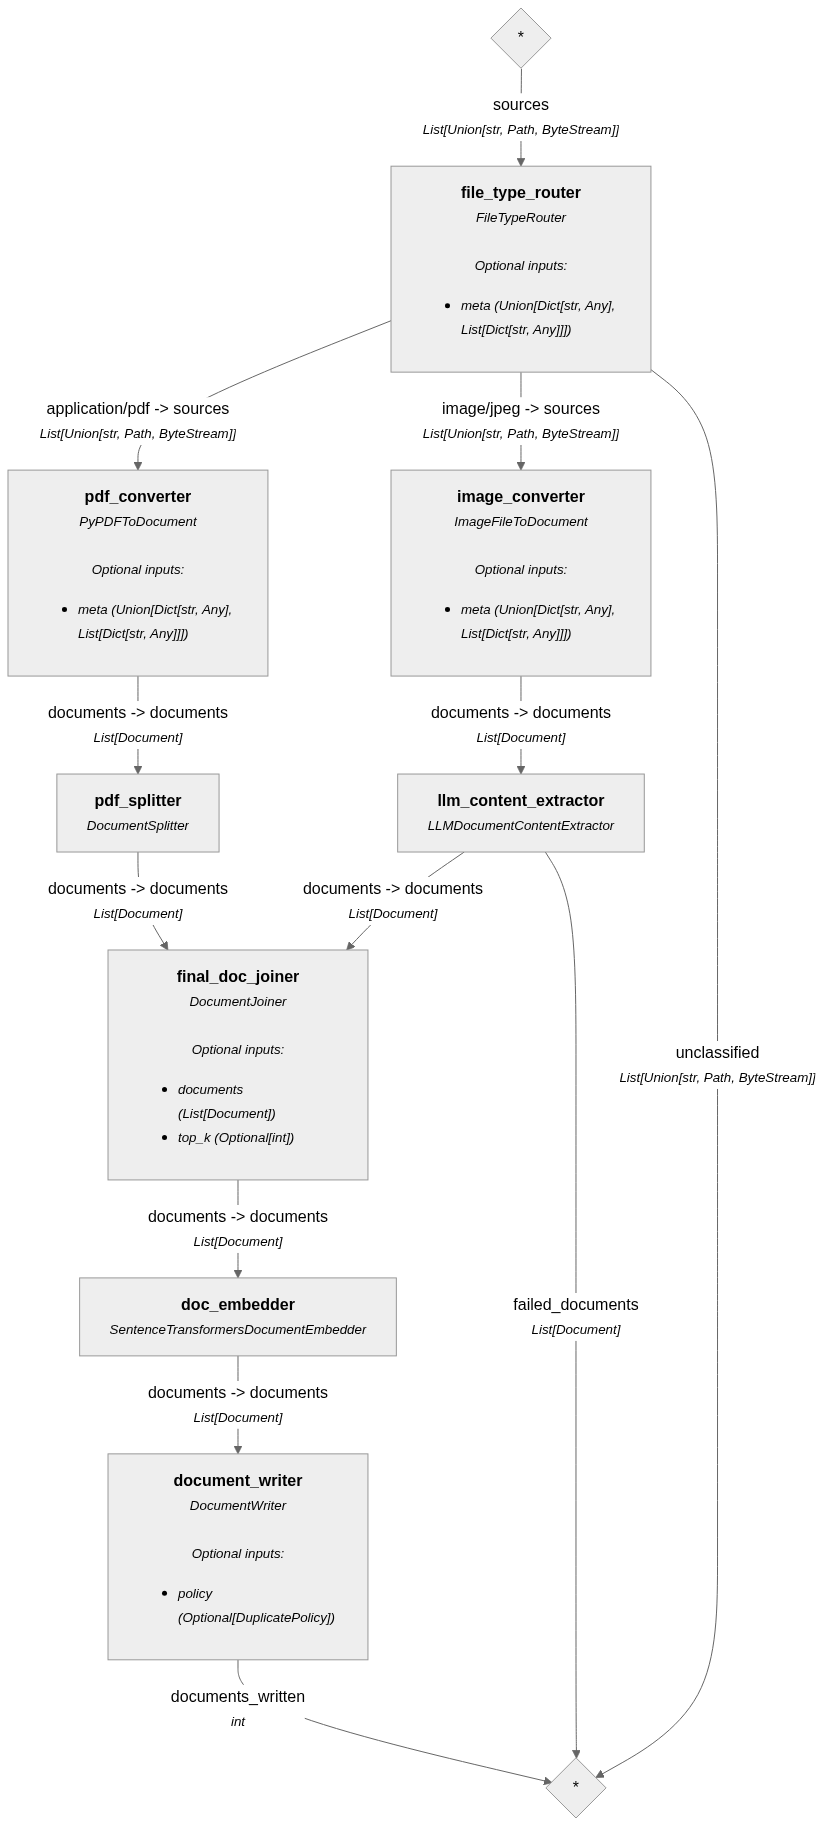

In [ ]:
# indexing_pipe.show()

In [19]:
indexing_result = indexing_pipe.run(
    data={"file_type_router": {"sources": ["attention_is_all_you_need.pdf", "apple.jpg"]}}
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [20]:
indexed_documents = doc_store.filter_documents()
print(f"Indexed {len(indexed_documents)} documents")

Indexed 16 documents


Let's inspect our image document to see what content was extracted

In [21]:
image_doc = [d for d in indexed_documents if d.meta.get("file_path") == "apple.jpg"]
image_doc

[Document(id=ab81e5b007d0016dc2221538326671e672f4f88f12abc4eae624332cf8dc812e, content: '[img-caption]A close-up image of a red and yellow apple sitting on a mat made of intertwined fibers....', meta: {'file_path': 'apple.jpg'}, embedding: vector of size 1024)]

Nice, we have a an image caption of our image of an apple!

Now, let's run the retrieval with the same query and see what we get.

In [24]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

retriever = InMemoryEmbeddingRetriever(document_store=doc_store)
text_embedder = SentenceTransformersTextEmbedder(model="mixedbread-ai/mxbai-embed-large-v1", progress_bar=False)
text_embedder.warm_up()
text_embedding = text_embedder.run(text="An image of an apple")["embedding"]
results = retriever.run(text_embedding)["documents"]

for idx, doc in enumerate(results[:5]):
    print(f"Document {idx+1}:")
    print(f"Score: {doc.score}")
    print(f"File Path: {doc.meta['file_path']}")
    print("")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Document 1:
Score: 0.8338395777659648
File Path: apple.jpg

Document 2:
Score: 0.4480617169535044
File Path: attention_is_all_you_need.pdf

Document 3:
Score: 0.4402123716426982
File Path: attention_is_all_you_need.pdf

Document 4:
Score: 0.42692298257800776
File Path: attention_is_all_you_need.pdf

Document 5:
Score: 0.415257131170211
File Path: attention_is_all_you_need.pdf



And now we can see that the document representing the apple.jpg file was retrieved first!
We can now use this approach retrieve the image document at query time **and** still use the image to answer a user's question.

## Multimodal RAG on Image + Text

In this section, we demonstrate a multimodal RAG pipeline that retrieves based on **textual image captions**, but uses the **original images** during generation. This allows us to combine the strengths of both modalities: fast and effective retrieval using a text-based index, and rich, grounded generation using visual inputs.

Specifically:

* During indexing, we use `LLMDocumentContentExtractor` to extract a caption from each image, which serves as the searchable text representation.
* At query time, these captions are embedded and used to retrieve relevant documents.
* Retrieved image documents are then passed through `DocumentToImageContent`, which converts them to base64 strings and packages them as `ImageContent`.
* These image objects are rendered directly in the prompt and sent to a vision-capable language model like `gpt-4o-mini`.

> One thing to notice here, this time, instead of passing a list of `ChatMessage` objects to `ChatPromptBuilder`, we define the roles directly within the prompt using `{%- message role="system" -%}` and `{%- message role="user" -%}`. We then render the base64 strings by using the `templatize_part` utility.

This approach makes it possible to retrieve both images and text with text, but still leverage the full detail of the image in the final answer.


In [64]:
from haystack import Pipeline
from haystack.components.embedders.sentence_transformers_text_embedder import SentenceTransformersTextEmbedder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.retrievers.in_memory.embedding_retriever import InMemoryEmbeddingRetriever
from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters.image import DocumentToImageContent
from haystack.components.routers import DocumentTypeRouter

text_embedder = SentenceTransformersTextEmbedder(model="mixedbread-ai/mxbai-embed-large-v1", progress_bar=False)
retriever = InMemoryEmbeddingRetriever(document_store=doc_store, top_k=3)
doc_type_router = DocumentTypeRouter(file_path_meta_field="file_path", mime_types=["image/jpeg", "application/pdf"])
doc_to_image = DocumentToImageContent(detail="auto")
chat_prompt_builder = ChatPromptBuilder(
    required_variables=["question"],
    template="""{% message role="system" %}
You are a friendly assistant that answers questions based on provided documents and images.
{% endmessage %}

{%- message role="user" -%}
Only provide an answer to the question using the images and text passages provided.

These are the text-only documents:
{%- if documents|length > 0 %}
{%- for doc in documents %}
Text Document [{{ loop.index }}] :
{{ doc.content }}
{% endfor -%}
{%- else %}
No relevant text documents were found.
{% endif %}
End of text documents.

Question: {{ question }}
Answer:

Images:
{%- if image_contents|length > 0 %}
{%- for img in image_contents -%}
  {{ img | templatize_part }}
{%- endfor -%}
{% endif %}
{%- endmessage -%}
""")
llm = OpenAIChatGenerator(model="gpt-4o-mini")

In [65]:
# Create the Query Pipeline
pipe = Pipeline()
pipe.add_component("text_embedder", text_embedder)
pipe.add_component("retriever", retriever)
pipe.add_component("doc_type_router", doc_type_router)
pipe.add_component("doc_to_image", doc_to_image)
pipe.add_component("chat_prompt_builder", chat_prompt_builder)
pipe.add_component("llm", llm)

pipe.connect("text_embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever.documents", "doc_type_router.documents")
pipe.connect("doc_type_router.image/jpeg", "doc_to_image.documents")
pipe.connect("doc_to_image.image_contents", "chat_prompt_builder.image_contents")
pipe.connect("doc_type_router.application/pdf", "chat_prompt_builder.documents")
pipe.connect("chat_prompt_builder.prompt", "llm.messages")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - doc_type_router: DocumentTypeRouter
  - doc_to_image: DocumentToImageContent
  - chat_prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> doc_type_router.documents (List[Document])
  - doc_type_router.image/jpeg -> doc_to_image.documents (List[Document])
  - doc_type_router.application/pdf -> chat_prompt_builder.documents (List[Document])
  - doc_to_image.image_contents -> chat_prompt_builder.image_contents (List[Optional[ImageContent]])
  - chat_prompt_builder.prompt -> llm.messages (List[ChatMessage])

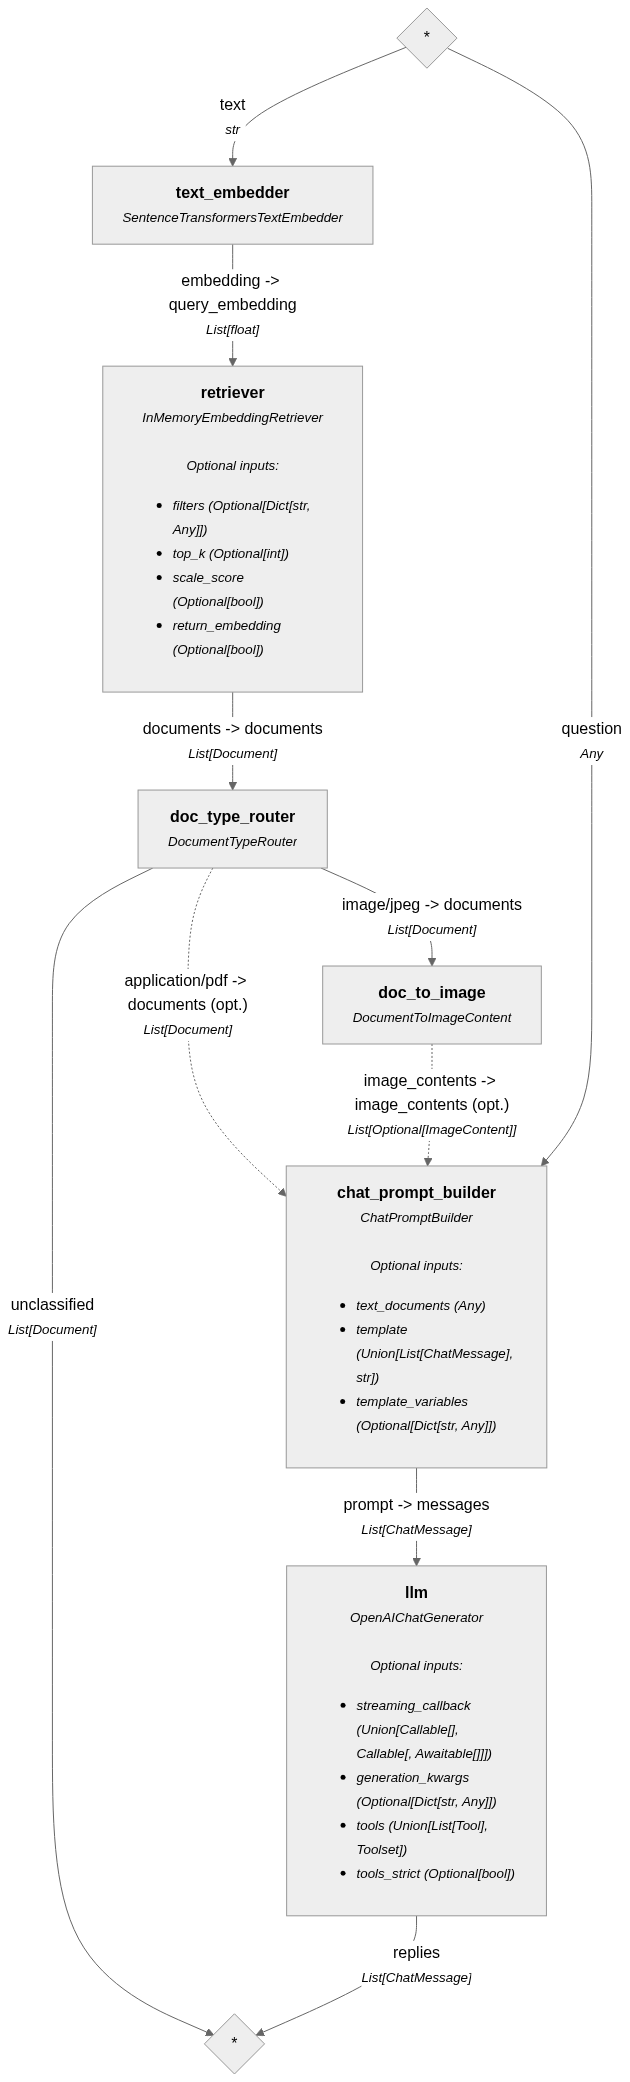

In [ ]:
# pipe.show()

When we send a query to our pipeline now, we'll receive a response based on the apple image. The `retriever` fetches the relevant data, and a vision-capable language model like `gpt-4o-mini` generates the response using the base64-encoded image.

In [66]:
# Run the pipeline with a query about the apple
query = "What is the color of the background of the image with an apple in it?"
result = pipe.run(
    data={"text_embedder": {"text": query}, "chat_prompt_builder": {"question": query}}
)
print(result["llm"]["replies"][0].text)

The color of the background of the image with the apple in it is a light brown.


In [ ]:
# Run the pipeline with a query about the pdf document
query = "What is attention in the transformers architecture?"
result = pipe.run(data={"text_embedder": {"text": query}, "chat_prompt_builder": {"question": query}})
print(result["llm"]["replies"][0].text)

Attention in the transformers architecture is a mechanism that allows the model to weigh the importance of different words or tokens in a sequence when processing input data. It enables the model to focus on relevant parts of the input when making predictions or generating outputs, effectively capturing relationships and context in the data.


## What's next

🎉 Congrats! You just built a multimodal RAG system with Haystack and tried out different ways to retrieve both image and text data.

You can follow the progress of the multimodal features in this [GitHub issue](https://github.com/deepset-ai/haystack/issues/8976).

Curious to keep exploring? Here are a few great next steps:

* [Creating a Multi-Agent System with Haystack](https://haystack.deepset.ai/tutorials/45_creating_a_multi_agent_system)
* [Building an Agentic RAG with Fallback to Websearch](https://haystack.deepset.ai/tutorials/36_building_fallbacks_with_conditional_routing)
* [AI Guardrails: Content Moderation and Safety with Open Language Models](https://haystack.deepset.ai/cookbook/safety_moderation_open_lms)

To stay up to date on the latest Haystack developments, you can [sign up for our newsletter](https://landing.deepset.ai/haystack-community-updates) or [join Haystack discord community](https://discord.gg/Dr63fr9NDS).

(*Notebook by [Sebastian Husch Lee](https://github.com/sjrl)*)